# spinal_test2.ipynb
Second test of the delegational learning rule in the context of the spinal cord project.
The task is the same as in spinal_test1.ipynb, but the am_pm_oscillator model is used.

Let $S_F, S_P, S_{P-F}, M_C$ denote the regions of the cortical model, and $s_F, s_P, s_{P-F}, m_C$ denote their current activities.
Assume that each unit $u_j$ in $M_C$ is associated with a vector $\bar{v}_j$, and that the ouput of the plant is $p = \sum_j u_j \bar{v}_j$. We also set $s_F = p$. The rule should be such that $p \approx s_P$.

The plant $P$ can be implemented as a population of linear units.
If the connection matrix from $M_C$ to $P$ is called $W$, then
$\bar{v}_j = (W_{1,j}, W_{2,j}, ..., W_{n,j})^T \equiv W_{:,j}$. 

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
# Create the neuronal populations
N = 8 # size of each population
des_pat = np.zeros(N) # desired pattern in SP
des_pat[np.arange(0,N,2)] = 1. # a one every other entry

net_params = {'min_delay' : 0.01,
              'min_buff_size' : 10 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.,
             'slope' : 1.,
             'init_val' : 0.5,
             'tau' : 0.05 }
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'function' : lambda x: None }
SPF1_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3,
              'slope' : 1.5,
              'init_val' : 0.3,
              'tau_fast': 0.08,
              'tau_mid': 0.5,
              'tau_slow' : 2.,
              'tau' : 0.05 }
SPF2_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3,
              'slope' : 1.5,
              'init_val' : 0.3,
              'tau_fast': 0.08,
              'tau_mid': 0.5,
              'tau_slow' : 2.,
              'tau' : 0.05,}
P_params = {'type' : unit_types.linear,
            'init_val' : 0.,
            'tau' : 0.05 }
M_params = {'type' : unit_types.am_pm_oscillator,
            'tau_u' : 0.05,
            'tau_c' : 1.,
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : [0.2, 0.2, 0., 0.2],
            'multidim' : True,
            'omega' : 5.,
            'F' : 'zero',
            'tau_fast': 0.1,
            'tau_mid' : 0.4,
            'tau_slow' : 2.,
            'delay' : 0.11 }

net = network(net_params)
SF = net.create(N, SF_params)
SP = net.create(N, SP_params)
SPF1 = net.create(N, SPF1_params)
SPF2 = net.create(N, SPF2_params)
P = net.create(N, P_params)
ME = net.create(N, M_params)
MI = net.create(N, M_params)

# set the pattern in SP
def make_fun(idx):
    return lambda t: des_pat[idx]
for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# Create the connections. See note on "detecting layer distances" in cortex wiki
SF__SPF1_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF2_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SF__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF1_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF2_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SPF1__ME_conn = {'rule': 'all_to_all',
                'delay': 0.02 }
SPF2__ME_conn = SPF1__ME_conn
SPF1__MI_conn = SPF1__ME_conn
SPF2__MI_conn = SPF1__ME_conn
SPF1__ME_syn = {'type' : synapse_types.diff_hebbsnorm,
                'lrate': .5,
                'post_delay': 10,
                'inp_ports': 0,
                'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
SPF2__ME_syn = SPF1__ME_syn
SPF1__MI_syn = SPF1__ME_syn
SPF2__MI_syn = SPF1__ME_syn
# Specify the connection matrix from ME/MI to P
W = 5.*np.eye(N)
ME__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
ME__P_syn = {'type': synapse_types.static,
             'init_w' : W.flatten() }
MI__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
MI__P_syn = {'type': synapse_types.static,
             'init_w' : -W.flatten() }
P__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 3. }
# mutual inhibition in M
ME__ME_conn = {'rule': 'all_to_all',
               'allow_autapses' : False,
               'delay' : 0.02 }
ME__ME_syn = {'type' : synapse_types.cov,
              'lrate' : 0.1,
              'inp_ports': 1,
              'init_w' : 0.05 }
ME__MI_conn = ME__ME_conn
ME__MI_syn = ME__ME_syn
MI__ME_conn = {'rule' : 'one_to_one',
               'delay' : 0.02 }
MI__ME_syn = {'type' : synapse_types.anticov_inh,
              'lrate' : -0.5,
              'inp_ports': 1,
              'init_w' : -2.5}
MI__MI_conn = ME__ME_conn
MI__MI_syn = {'type' : synapse_types.anticov_inh,
              'lrate' : -0.5,
              'inp_ports': 1,
              'init_w' : -.5}

net.connect(SF, SPF1, SF__SPF1_conn, SF__SPF1_syn)
net.connect(SF, SPF2, SF__SPF2_conn, SF__SPF2_syn)
net.connect(SP, SPF1, SP__SPF1_conn, SP__SPF1_syn)
net.connect(SP, SPF2, SP__SPF2_conn, SP__SPF2_syn)
net.connect(SPF1, ME, SPF1__ME_conn, SPF1__ME_syn)
net.connect(SPF1, MI, SPF1__MI_conn, SPF1__MI_syn)
net.connect(SPF2, ME, SPF2__ME_conn, SPF2__ME_syn)
net.connect(SPF2, MI, SPF2__MI_conn, SPF2__MI_syn)
net.connect(ME, P, ME__P_conn, ME__P_syn)
net.connect(MI, P, MI__P_conn, MI__P_syn)
net.connect(P, SF, P__SF_conn, P__SF_syn)
#net.connect(ME, ME, ME__ME_conn, ME__ME_syn)
net.connect(MI, MI, MI__MI_conn, MI__MI_syn)
net.connect(ME, MI, ME__MI_conn, ME__MI_syn)
net.connect(MI, ME, MI__ME_conn, MI__ME_syn)

In [3]:
start_time = time.time()
times, data, _  = net.run(.5)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 1.7945449352264404 seconds


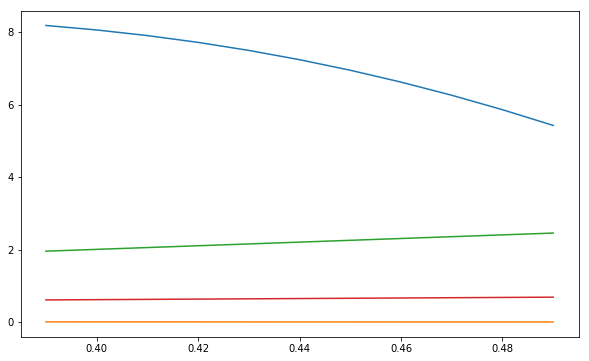

array([5.00515645e+00, 1.13543988e-03, 2.50000000e+00, 6.91868278e-01])

In [23]:
# unit ME[0]'s buffer
u_fig = plt.figure(figsize=(10,6))
u_data = net.units[ME[0]].buffer[:,0::10]
u_len = u_data.shape[1]
plt.plot(times[-u_len:], u_data.transpose())
plt.show()
net.units[ME[0]].buffer[:,-1]

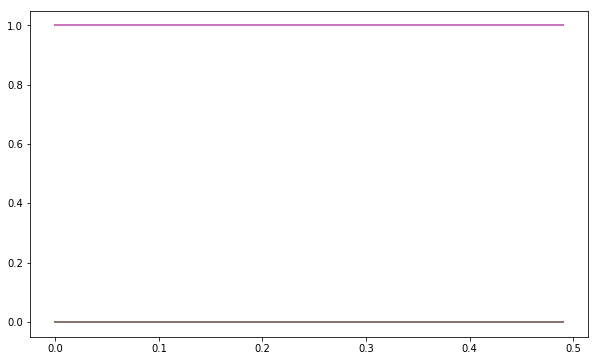

[1. 0. 1. 0. 1. 0. 1. 0.]


In [5]:
# SP
SP_fig = plt.figure(figsize=(10,6))
SP_data = np.array(data[SP])
plt.plot(times, SP_data.transpose())
plt.show()
print(SP_data[:,-1])

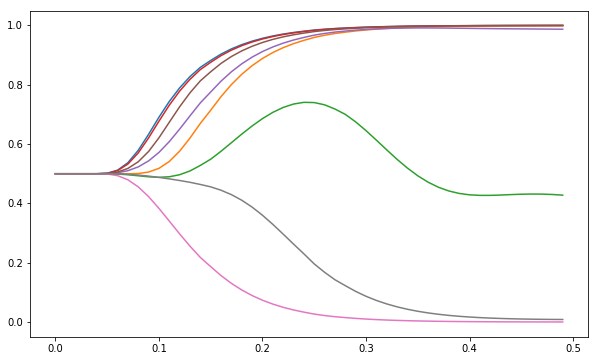

[9.99870604e-01 9.99347726e-01 4.27781136e-01 9.99863678e-01
 9.87174807e-01 9.99828127e-01 2.24020802e-04 8.59520155e-03]


In [6]:
# SF
SF_fig = plt.figure(figsize=(10,6))
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.show()
print(SF_data[:,-1])

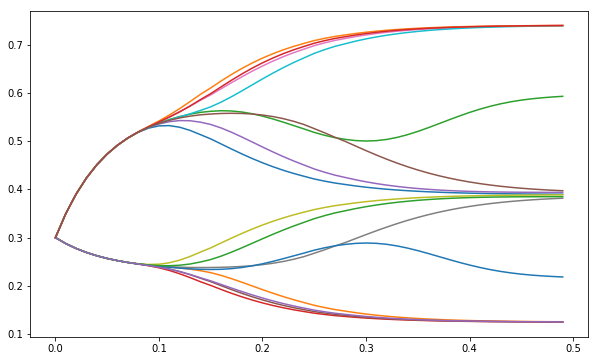

[0.38996395 0.12529161 0.59317767 0.12486994 0.39380488 0.12493977
 0.73995684 0.38172101 0.38876685 0.73950196 0.21828205 0.74022412
 0.38495697 0.74010479 0.12502515 0.39723469]


In [7]:
# SPF
SPF_fig = plt.figure(figsize=(10,6))
SPF_data = np.array(data[SPF1+SPF2])
plt.plot(times, SPF_data.transpose())
plt.show()
print(SPF_data[:,-1])

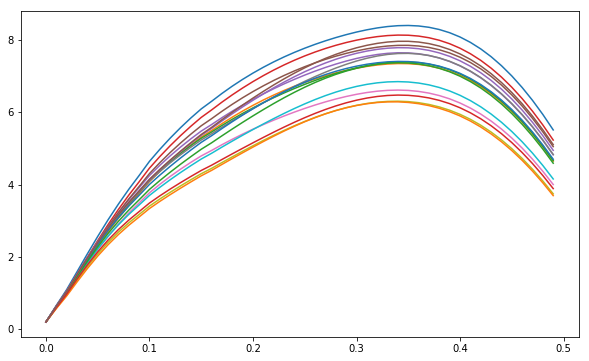

[5.51582254 4.65259406 4.66896206 5.23538902 4.82804956 5.05303605
 4.00412445 4.83489254 3.74677913 4.15830803 4.7051211  3.69763457
 4.59428101 3.89165256 4.95063823 5.10854623]


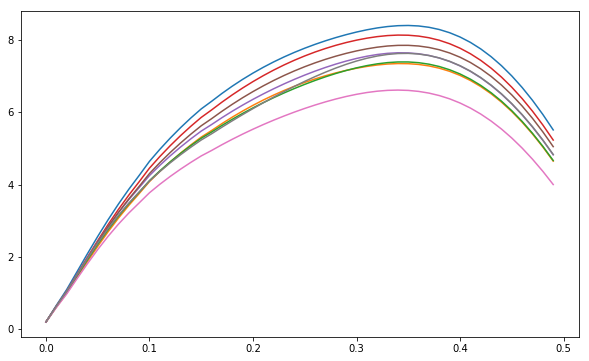

[5.51582254 4.65259406 4.66896206 5.23538902 4.82804956 5.05303605
 4.00412445 4.83489254]


In [8]:
# M
M_fig = plt.figure(figsize=(10,6))
M_data = np.array(data[ME+MI])
plt.plot(times, M_data.transpose())
plt.show()
print(M_data[:,-1])

ME_fig = plt.figure(figsize=(10,6))
ME_data = np.array(data[ME])
plt.plot(times, ME_data.transpose())
plt.show()
print(ME_data[:,-1])

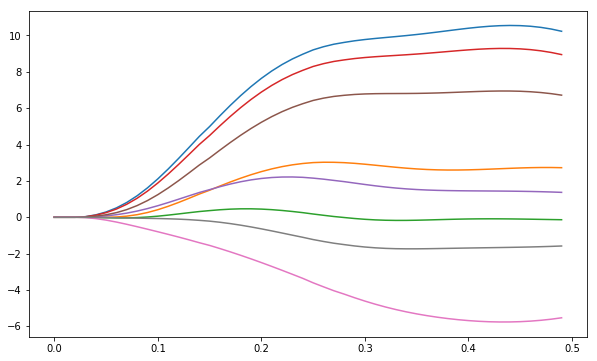

[10.22928684  2.72688781 -0.1345086   8.94662558  1.37054565  6.71621461
 -5.52813973 -1.57937216]


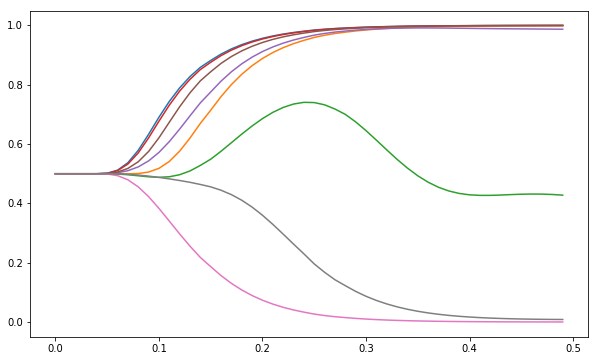

[9.99870604e-01 9.99347726e-01 4.27781136e-01 9.99863678e-01
 9.87174807e-01 9.99828127e-01 2.24020802e-04 8.59520155e-03]


In [9]:
# P
P_fig = plt.figure(figsize=(10,6))
P_data = np.array(data[P])
plt.plot(times, P_data.transpose())
plt.show()
print(P_data[:,-1])

# SF
SF_fig = plt.figure(figsize=(10,6))
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.show()
print(SF_data[:,-1])

In [10]:
for idx, syn in enumerate(net.syns[ME[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> ME, w=%f'%(idx, pre_pop, pre_id, syn.w))

0) SPF1 (16) --> ME, w=0.063058
1) SPF1 (17) --> ME, w=-0.007418
2) SPF1 (18) --> ME, w=0.123797
3) SPF1 (19) --> ME, w=0.031410
4) SPF1 (20) --> ME, w=0.100533
5) SPF1 (21) --> ME, w=0.014607
6) SPF1 (22) --> ME, w=0.151372
7) SPF1 (23) --> ME, w=0.077116
8) SPF2 (24) --> ME, w=0.059840
9) SPF2 (25) --> ME, w=0.162402
10) SPF2 (26) --> ME, w=0.051320
11) SPF2 (27) --> ME, w=0.132681
12) SPF2 (28) --> ME, w=0.045139
13) SPF2 (29) --> ME, w=0.163235
14) SPF2 (30) --> ME, w=0.028510
15) SPF2 (31) --> ME, w=0.078961
16) MI (48) --> ME, w=-172.928129


In [11]:
for idx, syn in enumerate(net.syns[MI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MI, w=%f'%(idx, pre_pop, pre_id, syn.w))

0) SPF1 (16) --> MI, w=0.069479
1) SPF1 (17) --> MI, w=0.046443
2) SPF1 (18) --> MI, w=0.083506
3) SPF1 (19) --> MI, w=0.013943
4) SPF1 (20) --> MI, w=0.065779
5) SPF1 (21) --> MI, w=0.043559
6) SPF1 (22) --> MI, w=0.133439
7) SPF1 (23) --> MI, w=0.065293
8) SPF2 (24) --> MI, w=0.058961
9) SPF2 (25) --> MI, w=0.102102
10) SPF2 (26) --> MI, w=0.036790
11) SPF2 (27) --> MI, w=0.123636
12) SPF2 (28) --> MI, w=0.060663
13) SPF2 (29) --> MI, w=0.111362
14) SPF2 (30) --> MI, w=0.014218
15) SPF2 (31) --> MI, w=0.076594
16) MI (49) --> MI, w=-14.900749
17) MI (50) --> MI, w=-19.887579
18) MI (51) --> MI, w=-11.287049
19) MI (52) --> MI, w=-18.552505
20) MI (53) --> MI, w=-12.345263
21) MI (54) --> MI, w=-23.090509
22) MI (55) --> MI, w=-24.342714
23) ME (40) --> MI, w=0.963776
24) ME (41) --> MI, w=0.850073
25) ME (42) --> MI, w=0.849796
26) ME (43) --> MI, w=0.933222
27) ME (44) --> MI, w=0.878110
28) ME (45) --> MI, w=0.901381
29) ME (46) --> MI, w=0.770623
30) ME (47) --> MI, w=0.861922


# PART 2
Open loop test of the `am_pm_oscillator` model.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
net_params = {'min_delay' : 0.01,
              'min_buff_size' : 10 }
osc_params = {'type' : unit_types.am_pm_oscillator,
            'tau_u' : 1.,
            'tau_c' : 1.,
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : [[0.2, 0.2, 0., 0.1], [0.5, 0.5, 0., 0.8]],
            'multidim' : True,
            'omega' : 1.,
            'F' : 'zero',
            'tau_fast': 0.1,
            'tau_mid' : 0.4,
            'tau_slow' : 2.,
            'delay' : 0.11 }
src_params = {'type' : unit_types.source,
              'init_val' : 1.,
              'function' : lambda t: np.sin(1.*t) }
net = network(net_params)
osc = net.create(2, osc_params)
src = net.create(1, src_params)
src__osc_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
src__osc_syn = {'type' : synapse_types.static,
                'inp_ports': 0,
                'init_w' : 1. }
net.connect(src, osc, src__osc_conn, src__osc_syn)

In [6]:
start_time = time.time()
#times, data, _  = net.flat_run(20.)
times, data, _  = net.run(100.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 1.7652833461761475 seconds


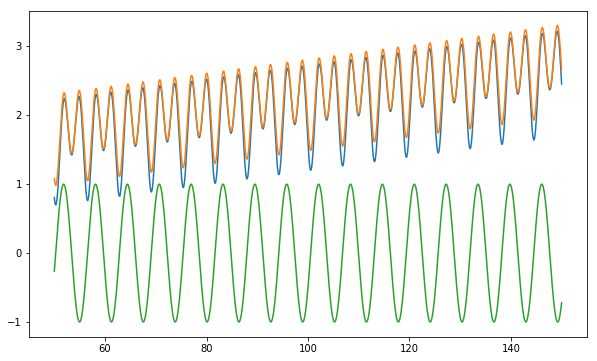

In [7]:
fig = plt.figure(figsize=(10,6))
plt.plot(times, data.transpose())
#plt.plot(times, np.sqrt(2.)*np.sin(2.*times), 'r')
plt.show()

In [8]:
print(net.units[0].buffer[:,-1])
print(net.units[1].buffer[:,-1])

[  2.44058      0.41169828 150.          -0.74211608]
[  2.64725558   0.63232058 150.          -0.74211608]


In [24]:
1. + 0.6068*np.sin(50.)

0.840790938772456